In [1]:
# for local
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os

EXP_NAME='1101_R_C_classificatoin_lstm_hidden=1024_ver11_mod-feat11'

DATA_DIR = "../input/ventilator-pressure-prediction/"

OUTPUT_DIR = f'./results/{EXP_NAME}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Config

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    experiment_name=EXP_NAME
    competition='ventilator'
    apex=True
    print_freq=1000
    num_workers=4
    model_name='lstm'
    scheduler='CosineAnnealingWarmRestarts' # ['linear', 'cosine', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    batch_scheduler=False
    #num_warmup_steps=100 # ['linear', 'cosine']
    #num_cycles=0.5 # 'cosine'
    factor=0.995 # ReduceLROnPlateau
    patience=7 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    T_max=50 # CosineAnnealingLR
    T_0=20 # CosineAnnealingWarmRestarts
    epochs=25
    max_grad_norm=1000
    gradient_accumulation_steps=1
    hidden_size=1024
    lr=1e-3
    min_lr=1e-5
    weight_decay=1e-6
    batch_size=512
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    cate_seq_cols=[]
    cont_seq_cols=['time_step', 'u_in', 'u_out']
    train=True
    inference=False
    feature_importance=False
    debug=False
    wandb=True

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold=[0]

# import

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import sys
import json
import math
import random
from time import time
from datetime import datetime
from collections import Counter, defaultdict

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from tqdm.auto import tqdm
import category_encoders as ce

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

import warnings
warnings.filterwarnings("ignore")

#if CFG.apex:
#    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
# def get_score(y_trues, y_preds):
#     score = mean_absolute_error(y_trues, y_preds)
#     return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

# data loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(DATA_DIR + 'train.csv')
if CFG.debug:
    train = train[:80*5000]
test = pd.read_csv(DATA_DIR + 'test.csv')
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

display(train.head())
display(test.head())
display(sub.head())

unique_pressures = train["pressure"].unique()
sorted_pressures = np.sort(unique_pressures)
total_pressures_len = len(sorted_pressures)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# create features

In [7]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()


class AddMultiplyingDividing(AbstractBaseBlock):
    def transform(self, input_df):
        input_df['area'] = input_df['time_step'] * input_df['u_in']
        input_df['area'] = input_df.groupby('breath_id')['area'].cumsum()
        input_df['cross'] = input_df['u_in']*input_df['u_out']
        input_df['cross2'] = input_df['time_step']*input_df['u_out']
        input_df['u_in_cumsum'] = (input_df['u_in']).groupby(input_df['breath_id']).cumsum()
        input_df['one'] = 1
        input_df['count'] = (input_df['one']).groupby(input_df['breath_id']).cumsum()
        input_df['u_in_cummean'] = input_df['u_in_cumsum'] / input_df['count']
        # input_df = input_df.merge(
        #     input_df[input_df["u_out"]==0].groupby('breath_id')['u_in'].agg(["mean", "std", "max"]).add_prefix("u_out0_").reset_index(),
        #     on="breath_id"
        # )
        # input_df = input_df.merge(
        #     input_df[input_df["u_out"]==1].groupby('breath_id')['u_in'].agg(["mean", "std", "max"]).add_prefix("u_out1_").reset_index(),
        #     on="breath_id"
        # )

        # feat-11
        input_df['time_step_cumsum'] = input_df.groupby(['breath_id'])['time_step'].cumsum()
        input_df['breath_id__u_in__max'] = input_df.groupby(['breath_id'])['u_in'].transform('max')
        input_df['breath_id__u_in__mean'] = input_df.groupby(['breath_id'])['u_in'].transform('mean')
        input_df['breath_id__u_in__diffmax'] = input_df.groupby(['breath_id'])['u_in'].transform('max') - input_df['u_in']
        input_df['breath_id__u_in__diffmean'] = input_df.groupby(['breath_id'])['u_in'].transform('mean') - input_df['u_in']

        output_df = pd.DataFrame(
            {
                "area": input_df['area'],
                #"cross": input_df['cross'],
                #"cross2": input_df['cross2'],
                "u_in_cumsum": input_df['u_in_cumsum'],
                "u_in_cummean": input_df['u_in_cummean'],
                'time_step_cumsum': input_df['time_step_cumsum'],
                "breath_id__u_in__max": input_df['breath_id__u_in__max'],
                "breath_id__u_in__mean": input_df['breath_id__u_in__mean'],
                "breath_id__u_in__diffmax": input_df['breath_id__u_in__diffmax'],
                "breath_id__u_in__diffmean": input_df['breath_id__u_in__diffmean'],
                'count': input_df['count'],

            }
        )
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df


# class RCDummry(AbstractBaseBlock):
#     def transform(self, input_df):
#         input_df['R_dummy'] = input_df['R'].astype(str)
#         input_df['C_dummy'] = input_df['C'].astype(str)
#         #input_df['RC_dummy'] = input_df['R_dummy'] + input_df['C_dummy']
#         output_df = pd.get_dummies(input_df[["R_dummy", "C_dummy"]])
#         CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
#         return output_df


class AddBreathTimeAndUInTime(AbstractBaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame(
            {
                "breath_time": input_df['time_step'] - input_df['time_step'].shift(1),
                "u_in_time": input_df['u_in'] - input_df['u_in'].shift(1)
            }
        )
        output_df.loc[input_df['time_step'] == 0, 'breath_time'] = output_df['breath_time'].mean()
        output_df.loc[input_df['time_step'] == 0, 'u_in_time'] = output_df['u_in_time'].mean()
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df

class LagFeatures(AbstractBaseBlock):
    def transform(self, input_df):
        output_df = pd.DataFrame(
            {
                "u_in_lag1": input_df.groupby("breath_id")["u_in"].shift(1).fillna(0),
                "u_in_lag2": input_df.groupby("breath_id")["u_in"].shift(2).fillna(0),
                "u_in_lag3": input_df.groupby("breath_id")["u_in"].shift(3).fillna(0),
                "u_in_lag4": input_df.groupby("breath_id")["u_in"].shift(4).fillna(0),
                "u_in_lag-1": input_df.groupby("breath_id")["u_in"].shift(-1).fillna(0),
                "u_in_lag-2": input_df.groupby("breath_id")["u_in"].shift(-2).fillna(0),
                "u_in_lag-3": input_df.groupby("breath_id")["u_in"].shift(-3).fillna(0),
                "u_in_lag-4": input_df.groupby("breath_id")["u_in"].shift(-4).fillna(0),
                "u_out_lag1": input_df.groupby("breath_id")["u_out"].shift(1).fillna(0),
                "u_out_lag2": input_df.groupby("breath_id")["u_out"].shift(2).fillna(0),
                "u_out_lag3": input_df.groupby("breath_id")["u_out"].shift(3).fillna(0),
                "u_out_lag4": input_df.groupby("breath_id")["u_out"].shift(4).fillna(0),
                "u_out_lag-1": input_df.groupby("breath_id")["u_out"].shift(-1).fillna(0),
                "u_out_lag-2": input_df.groupby("breath_id")["u_out"].shift(-2).fillna(0),
                "u_out_lag-3": input_df.groupby("breath_id")["u_out"].shift(-3).fillna(0),
                "u_out_lag-4": input_df.groupby("breath_id")["u_out"].shift(-4).fillna(0),
            }
        )
        output_df["u_in_lag1_diff"] = input_df["u_in"] - output_df["u_in_lag1"]
        output_df["u_in_lag2_diff"] = input_df["u_in"] - output_df["u_in_lag2"]
        output_df["u_in_lag3_diff"] = input_df["u_in"] - output_df["u_in_lag3"]
        output_df["u_in_lag4_diff"] = input_df["u_in"] - output_df["u_in_lag4"]
        output_df["u_out_lag1_diff"] = input_df["u_out"] - output_df["u_out_lag1"]
        output_df["u_out_lag2_diff"] = input_df["u_out"] - output_df["u_out_lag2"]
        output_df["u_out_lag3_diff"] = input_df["u_out"] - output_df["u_out_lag3"]
        output_df["u_out_lag4_diff"] = input_df["u_out"] - output_df["u_out_lag4"]
        output_df["u_in_lag-1_diff"] = input_df["u_in"] - output_df["u_in_lag-1"]
        output_df["u_in_lag-2_diff"] = input_df["u_in"] - output_df["u_in_lag-2"]
        output_df["u_out_lag-1_diff"] = input_df["u_out"] - output_df["u_out_lag-1"]
        output_df["u_out_lag-2_diff"] = input_df["u_out"] - output_df["u_out_lag-2"]

        output_df['u_in_ewm9'] = (input_df.groupby('breath_id')['u_in'].ewm(halflife=9).mean().reset_index(level=0,drop=True))
        output_df['u_in_ewm15'] = (input_df.groupby('breath_id')['u_in'].ewm(halflife=15).mean().reset_index(level=0,drop=True))

        # output_df["u_in_rolling_mean2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).mean()["u_in"].reset_index(drop=True)
        output_df["u_in_rolling_mean4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).mean()["u_in"].reset_index(drop=True)
        output_df["u_in_rolling_mean15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).mean()["u_in"].reset_index(drop=True)
        if not CFG.debug:
            # output_df["u_in_rolling_max2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).max()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_max4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).max()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_max15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).max()["u_in"].reset_index(drop=True)
            # output_df["u_in_rolling_min2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).min()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_min4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).min()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_min15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).min()["u_in"].reset_index(drop=True)
            # output_df["u_in_rolling_std2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).std()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_std4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).std()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_std15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).std()["u_in"].reset_index(drop=True)
            # output_df["u_in_rolling_sum2"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(2).sum()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_sum4"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(4).sum()["u_in"].reset_index(drop=True)
            output_df["u_in_rolling_sum15"] = input_df[["breath_id", "u_in"]].groupby("breath_id").rolling(15).sum()["u_in"].reset_index(drop=True)
        for col in output_df.columns:
            output_df[col] = output_df[col].fillna(output_df[col].mean())
        CFG.cont_seq_cols += output_df.add_suffix(f'@{self.__class__.__name__}').columns.tolist()
        return output_df

In [8]:
feature_blocks = [
    AddMultiplyingDividing(),
    AddBreathTimeAndUInTime(),
    # RCDummry(),
    LagFeatures()
]

In [9]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()

    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='out_df shape: {} \t- {}'.format(out_df.shape, str(block))):
                if not test:
                    out_i = block.fit(input_df.copy(), y=y)
                else:
                    out_i = block.transform(input_df.copy())

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)
    print(f"out_df shape: {out_df.shape}")

    return pd.concat([input_df, out_df], axis=1)

train = run_blocks(train, blocks=feature_blocks)
test = run_blocks(test, blocks=feature_blocks, test=True)

CFG.cont_seq_cols = list(set(CFG.cont_seq_cols))
display(train.head())
display(test.head())

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
out_df shape: (0, 0) 	- <__main__.AddMultiplyingDividing object at 0x7f148d9adf10> 1.141[s]
out_df shape: (6036000, 9) 	- <__main__.AddBreathTimeAndUInTime object at 0x7f148d9ad750> 0.156[s]
out_df shape: (6036000, 11) 	- <__main__.LagFeatures object at 0x7f148d9add90> 59.904[s]
run test=False 62.597[s]
out_df shape: (6036000, 51)
★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
out_df shape: (0, 0) 	- <__main__.AddMultiplyingDividing object at 0x7f148d9adf10> 0.652[s]
out_df shape: (4024000, 9) 	- <__main__.AddBreathTimeAndUInTime object at 0x7f148d9ad750> 0.052[s]
out_df shape: (4024000, 11) 	- <__main__.LagFeatures object at 0x7f148d9add90> 39.858[s]
run test=True 41.414[s]
out_df shape: (4024000, 51)


,id,breath_id,R,C,time_step,u_in,u_out,pressure,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,count@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.083334,0.083334,0.000000,28.313036,10.146007,28.229702,10.062673,1,4.370474e-07,2.318432e-07,0.000000,0.000000,0.000000,0.000000,18.383041,22.509278,22.808822,25.355850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083334,0.083334,0.083334,0.083334,0.0,0.0,0.0,0.0,-18.299707,-22.425944,0.0,0.0,0.083334,0.083334,7.122734,6.293573,9.024859,11.255598,5.530754,2.927842,1.644297,2.874732,28.490936,94.403589
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.618632,18.466375,9.233188,0.033652,28.313036,10.146007,9.929994,-8.237035,2,3.365231e-02,1.829971e+01,0.083334,0.000000,0.000000,0.000000,22.509278,22.808822,25.355850,27.259866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.299707,18.383041,18.383041,18.383041,0.0,0.0,0.0,0.0,-4.126236,-4.425781,0.0,0.0,9.585358,9.444557,7.122734,6.293573,9.024859,11.255598,5.530754,2.927842,1.644297,2.874732,28.490936,94.403589
2,3,1,20,50,0.067514,22.509278,0,7.876254,2.138333,40.975653,13.658551,0.101167,28.313036,10.146007,5.803758,-12.363271,3,3.386211e-02,4.126236e+00,18.383041,0.083334,0.000000,0.000000,22.808822,25.355850,27.259866,27.127486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.126236,22.425944,22.509278,22.509278,0.0,0.0,0.0,0.0,-0.299544,-2.846573,0.0,0.0,14.229040,14.002181,7.122734,6.293573,9.024859,11.255598,5.530754,2.927842,1.644297,2.874732,28.490936,94.403589
3,4,1,20,50,0.101542,22.808822,0,11.742872,4.454391,63.784476,15.946119,0.202709,28.313036,10.146007,5.504214,-12.662816,4,3.402781e-02,2.995445e-01,22.509278,18.383041,0.083334,0.000000,25.355850,27.259866,27.127486,26.807732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299544,4.425781,22.725488,22.808822,0.0,0.0,0.0,0.0,-2.547028,-4.451044,0.0,0.0,16.627759,16.358716,15.946119,6.293573,22.808822,11.255598,0.083334,2.927842,10.766279,2.874732,63.784476,94.403589
4,5,1,20,50,0.135756,25.355850,0,12.234987,7.896588,89.140326,17.828065,0.338464,28.313036,10.146007,2.957185,-15.209844,5,3.421330e-02,2.547028e+00,22.808822,22.509278,18.383041,0.083334,27.259866,27.127486,26.807732,27.864715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.547028,2.846573,6.972809,25.272516,0.0,0.0,0.0,0.0,-1.904016,-1.771635,0.0,0.0,18.652046,18.328164,22.264248,6.293573,25.355850,11.255598,18.383041,2.927842,2.885502,2.874732,89.056992,94.403589


,id,breath_id,R,C,time_step,u_in,u_out,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,count@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures
0,1,0,5,20,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,37.542219,9.327338,37.542219,9.327338,1,6.623513e-07,0.000001,0.000000,0.000000,0.000000,0.0,7.515046,14.651675,21.230610,26.320956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-7.515046,-14.651675,0.0,0.0,0.000000,0.000000,7.138082,6.302657,9.042205,11.266123,5.545624,2.935795,1.645458,2.877506,28.552326,94.53985
1,2,0,5,20,0.031904,7.515046,0,0.239758,7.515046,3.757523,0.031904,37.542219,9.327338,30.027173,1.812292,2,3.190374e-02,7.515046,0.000000,0.000000,0.000000,0.0,14.651675,21.230610,26.320956,30.486938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.515046,7.515046,7.515046,7.515046,0.0,0.0,0.0,0.0,-7.136630,-13.715564,0.0,0.0,3.902147,3.844325,7.138082,6.302657,9.042205,11.266123,5.545624,2.935795,1.645458,2.877506,28.552326,94.53985
2,3,0,5,20,0.063827,14.651675,0,1.174935,22.166721,7.388907,0.095731,37.542219,9.327338,22.890543,-5.324338,3,3.192353e-02,7.136630,7.515046,0.000000,0.000000,0.0,21.230610,26.320956,30.486938,33.545950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.136630,14.651675,14.651675,14.651675,0.0,0.0,0.0,0.0,-6.578935,-11.669281,0.0,0.0,7.764551,7.614466,7.138082,6.302657,9.042205,11.266123,5.545624,2.935795,1.645458,2.877506,28.552326,94.53985
3,4,0,5,20,0.095751,21.230610,0,3.207788,43.397331,10.849333,0.191482,37.542219,9.327338,16.311609,-11.903272,4,3.192377e-02,6.578935,14.651675,7.515046,0.000000,0.0,26.320956,30.486938,33.545950,35.717600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.578935,13.715564,21.230610,21.230610,0.0,0.0,0.0,0.0,-5.090346,-9.256328,0.0,0.0,11.529365,11.257957,10.849333,6.302657,21.230610,11.266123,0.000000,2.935795,9.147936,2.877506,43.397331,94.53985
4,5,0,5,20,0.127644,26.320956,0,6.567489,69.718287,13.943657,0.319126,37.542219,9.327338,11.221263,-16.993619,5,3.189254e-02,5.090346,21.230610,14.651675,7.515046,0.0,30.486938,33.545950,35.717600,36.971061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.090346,11.669281,18.805911,26.320956,0.0,0.0,0.0,0.0,-4.165982,-7.224994,0.0,0.0,14.959946,14.555207,17.429572,6.302657,26.320956,11.266123,7.515046,2.935795,8.155144,2.877506,69.718287,94.53985


# normalization

In [10]:
train_col_order = ["u_out"] + train.columns.drop("u_out").tolist()
test_col_order = ["u_out"] + test.columns.drop("u_out").tolist()
train = train[train_col_order]
test = test[test_col_order]
scaler = RobustScaler()
scaler_targets = [col for col in CFG.cont_seq_cols if col != "u_out"]
print(f"Apply Standerd Scaler these columns: {scaler_targets}")
for scaler_target in tqdm(scaler_targets):
    scaler.fit(train.loc[:,[scaler_target]])
    train.loc[:,[scaler_target]] = scaler.transform(train.loc[:,[scaler_target]])
    test.loc[:,[scaler_target]] = scaler.transform(test.loc[:,[scaler_target]])
display(train.head())
display(test.head())

Apply Standerd Scaler these columns: ['u_out_lag-2@LagFeatures', 'u_out_lag2_diff@LagFeatures', 'breath_time@AddBreathTimeAndUInTime', 'time_step', 'u_out_lag3_diff@LagFeatures', 'u_in_rolling_min4@LagFeatures', 'u_in_lag-3@LagFeatures', 'u_in_lag3_diff@LagFeatures', 'u_out_lag-2_diff@LagFeatures', 'breath_id__u_in__diffmax@AddMultiplyingDividing', 'u_in_lag4_diff@LagFeatures', 'u_in_rolling_min15@LagFeatures', 'u_in_lag1@LagFeatures', 'u_in_lag-1_diff@LagFeatures', 'u_in_rolling_sum4@LagFeatures', 'u_out_lag1@LagFeatures', 'breath_id__u_in__mean@AddMultiplyingDividing', 'u_in_rolling_mean4@LagFeatures', 'area@AddMultiplyingDividing', 'u_in_lag3@LagFeatures', 'u_out_lag-1@LagFeatures', 'u_in_rolling_max4@LagFeatures', 'breath_id__u_in__diffmean@AddMultiplyingDividing', 'u_in_lag-1@LagFeatures', 'u_out_lag-1_diff@LagFeatures', 'u_in_cumsum@AddMultiplyingDividing', 'u_in_ewm9@LagFeatures', 'u_in_lag2@LagFeatures', 'u_in_lag-2_diff@LagFeatures', 'u_in_lag2_diff@LagFeatures', 'u_in_lag1_di

  0%|          | 0/53 [00:00<?, ?it/s]

,u_out,id,breath_id,R,C,time_step,u_in,pressure,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,count@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures
0,0,1,1,20,50,-0.989052,-0.937384,5.837492,-0.516581,-0.725228,-0.648438,-0.496658,0.112208,0.908069,0.326941,1.273864,-1.000000,-15.475736,-0.044814,-0.864121,-0.842527,-0.819258,-0.794152,2.890207,3.664026,3.743915,4.277824,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.471409,0.217993,0.121028,0.068315,0.0,0.0,0.0,0.0,-124.171952,-67.568904,0.0,0.0,-0.674415,-0.645875,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347
1,0,2,1,20,50,-0.963608,3.049278,5.907794,-0.514031,-0.676829,0.162935,-0.496024,0.112208,0.908069,-0.178436,-1.450205,-0.974684,0.103311,124.171952,-0.847360,-0.842527,-0.819258,-0.794152,3.739712,3.724218,4.256189,4.661047,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,113.467773,58.762670,38.091005,26.306250,0.0,0.0,0.0,0.0,-27.963705,-13.306889,0.0,0.0,0.822722,0.602444,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347
2,0,3,1,20,50,-0.938006,3.948195,7.876254,-0.507768,-0.617568,0.555359,-0.494752,0.112208,0.908069,-0.292389,-2.064430,-0.949367,0.200442,27.963705,2.833140,-0.825784,-0.819258,-0.794152,3.801381,4.236036,4.639136,4.634403,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,25.549576,71.696779,46.652513,32.222406,0.0,0.0,0.0,0.0,-1.988466,-8.546320,0.0,0.0,1.554380,1.210203,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347
3,0,4,1,20,50,-0.912278,4.013452,11.742872,-0.498222,-0.557517,0.758212,-0.492839,0.112208,0.908069,-0.300662,-2.109020,-0.924051,0.277152,1.988466,3.663022,2.850764,-0.802501,-0.794152,4.325760,4.618643,4.612511,4.570046,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.812565,14.110409,47.101127,32.651890,0.0,0.0,0.0,0.0,-17.244182,-13.383045,0.0,0.0,1.932321,1.524447,2.122094,0.369347,2.723238,0.88922,-0.754615,0.316541,11.831559,0.575588,2.122094,0.369347
4,0,5,1,20,50,-0.886409,4.568332,12.234987,-0.484036,-0.490761,0.925096,-0.490282,0.112208,0.908069,-0.371002,-2.488167,-0.898734,0.363024,17.244182,3.723268,3.679756,2.877119,-0.777379,4.717757,4.592042,4.548200,4.782785,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,15.753730,9.058184,14.415967,36.184309,0.0,0.0,0.0,0.0,-12.879471,-5.305890,0.0,0.0,2.251268,1.787073,3.298583,0.369347,3.107558,0.88922,2.938328,0.316541,3.007792,0.575588,3.298583,0.369347


,u_out,id,breath_id,R,C,time_step,u_in,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,count@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures
0,0,1,0,5,20,-0.989052,-0.955539,-0.516581,-0.725447,-0.655828,-0.496658,0.334664,0.749398,0.584122,1.164403,-1.000000,-15.475632,-0.044807,-0.864121,-0.842527,-0.819258,-0.794152,0.652718,2.085062,3.426496,4.472072,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.045513,-0.048610,-0.051881,-0.051169,0.0,0.0,0.0,0.0,-50.966638,-44.133146,0.0,0.0,-0.687545,-0.656988,0.481963,0.371377,0.646003,0.890709,0.347693,0.318837,1.619368,0.576711,0.481963,0.371377
1,0,2,0,5,20,-0.964930,0.681643,-0.515592,-0.705662,-0.322625,-0.496057,0.334664,0.749398,0.376581,0.045724,-0.974684,-0.706181,50.966638,-0.864121,-0.842527,-0.819258,-0.794152,2.121998,3.407081,4.450297,5.310562,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46.570397,23.993628,15.541051,10.723828,0.0,0.0,0.0,0.0,-48.397986,-41.311212,0.0,0.0,-0.072723,-0.144347,0.481963,0.371377,0.646003,0.890709,0.347693,0.318837,1.619368,0.576711,0.481963,0.371377
2,0,3,0,5,20,-0.940793,2.236385,-0.511738,-0.667087,-0.000608,-0.494854,0.334664,0.749398,0.179491,-1.016625,-0.949367,-0.697020,48.397986,0.647331,-0.842527,-0.819258,-0.794152,3.476461,4.429972,5.288183,5.926252,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.223080,46.825233,30.348811,20.956255,0.0,0.0,0.0,0.0,-44.612401,-35.142630,0.0,0.0,0.535836,0.358401,0.481963,0.371377,0.646003,0.890709,0.347693,0.318837,1.619368,0.576711,0.481963,0.371377
3,0,4,0,5,20,-0.916656,3.669632,-0.503360,-0.611192,0.306249,-0.493051,0.334664,0.749398,-0.002197,-1.995956,-0.924051,-0.696909,44.612401,2.082674,0.667302,-0.819258,-0.794152,4.524455,5.267114,5.903430,6.363341,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,40.763690,43.830413,43.999411,30.389065,0.0,0.0,0.0,0.0,-34.507996,-27.868713,0.0,0.0,1.129020,0.844261,1.173029,0.371377,2.485103,0.890709,-0.771432,0.318837,10.019570,0.576711,1.173029,0.371377
4,0,5,0,5,20,-0.892543,4.778584,-0.489513,-0.541895,0.580642,-0.490646,0.334664,0.749398,-0.142776,-2.753697,-0.898734,-0.711369,34.507996,3.405852,2.101105,0.691833,-0.794152,5.382142,5.881814,6.340205,6.615627,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,31.529960,37.283914,38.968414,37.687552,0.0,0.0,0.0,0.0,-28.233492,-21.745198,0.0,0.0,1.669541,1.283949,2.398325,0.371377,3.253182,0.890709,0.745129,0.318837,8.907984,0.576711,2.398325,0.371377


# reshape

In [11]:
train['R_C'] = train['R'].astype(str) + '_' + train['C'].astype(str)
test['R_C'] = test['R'].astype(str) + '_' + test['C'].astype(str)
CFG.cont_seq_cols += ['R_C']

print(set(train.drop(['R', 'C', "id", "breath_id", "pressure"], axis=1).columns) - set(CFG.cont_seq_cols))
print(train.drop(['R', 'C', "id", "breath_id", "pressure"], axis=1).shape)
print(len(CFG.cont_seq_cols))

le = preprocessing.LabelEncoder()

X = np.float32(train.drop(['R', 'C', "id", "breath_id", "pressure"], axis=1)).reshape(-1, 80, len(CFG.cont_seq_cols))
y = le.fit_transform(train[train['count@AddMultiplyingDividing']==1]["R_C"])
X_test = np.float32(test.drop(['R', 'C', "id", "breath_id"], axis=1)).reshape(-1, 80, len(CFG.cont_seq_cols))

set()
(6036000, 55)
55


# cv split

In [12]:
# ====================================================
# CV split
# ====================================================
# Fold = GroupKFold(n_splits=5)
# groups = train['breath_id'].values
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['pressure'], groups)):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# print(train.groupby('fold').size())

# Dataset

In [13]:
# ====================================================
# Dataset
# ====================================================
# class TrainDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.groups = df.groupby('breath_id').groups
#         self.keys = list(self.groups.keys())
#         
#     def __len__(self):
#         return len(self.groups)
# 
#     def __getitem__(self, idx):
#         indexes = self.groups[self.keys[idx]]
#         df = self.df.iloc[indexes]
#         cont_seq_x = torch.FloatTensor(df[CFG.cont_seq_cols].values)
#         u_out = torch.LongTensor(df['u_out'].values)
#         label = torch.FloatTensor(df['pressure'].values)
#         return cont_seq_x, u_out, label
#     
# 
# class TestDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.groups = df.groupby('breath_id').groups
#         self.keys = list(self.groups.keys())
#         
#     def __len__(self):
#         return len(self.groups)
# 
#     def __getitem__(self, idx):
#         indexes = self.groups[self.keys[idx]]
#         df = self.df.iloc[indexes]
#         cont_seq_x = torch.FloatTensor(df[CFG.cont_seq_cols].values)
#         return cont_seq_x

# Loss

In [14]:
# class L1Loss_masked(nn.Module):
#     def __init__(self):
#         super().__init__()
#     def forward(self, preds, y, u_out):

#         mask = 1 - u_out
#         mae = torch.abs(mask * (y - preds))
#         mae = torch.sum(mae) / torch.sum(mask)

#         return mae

# Model

In [15]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.hidden_size = cfg.hidden_size
        # self.seq_emb = nn.Sequential(
        #     nn.Linear(len(cfg.cont_seq_cols), self.hidden_size),
        #     nn.LayerNorm(self.hidden_size),
        #     nn.GELU(),
        #     #nn.Dropout(0.1),
        # )
        self.lstm1 = nn.LSTM(len(cfg.cont_seq_cols), self.hidden_size, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(self.hidden_size * 2, self.hidden_size//2, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(self.hidden_size//2 * 2, self.hidden_size//4, batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(self.hidden_size//2 * 2 + self.hidden_size//4 * 2, self.hidden_size//8, batch_first=True, bidirectional=True)
        self.linears1 = nn.Sequential(
            # nn.LayerNorm(self.hidden_size//16 * 2),
            nn.Linear(self.hidden_size//8 * 2, 100),
            nn.SELU(),
        )
        self.linears2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.SELU(),
        )
        self.linears3 = nn.Sequential(
            nn.Linear(100, 100),
            nn.SELU(),
        )
        self.head = nn.Sequential(
            nn.Linear(self.hidden_size//8 * 2 + 100 * 3, 9)
        )
        
        for n, m in self.named_modules():
            if isinstance(m, nn.LSTM):
                print(f'init {m}')
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.orthogonal_(param.data)
                    else:
                        nn.init.normal_(param.data)
            elif isinstance(m, nn.GRU):
                print(f"init {m}")
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        init.orthogonal_(param.data)
                    else:
                        init.normal_(param.data)

    def forward(self, cont_seq_x):
        x1, _ = self.lstm1(cont_seq_x)
        x2, _ = self.lstm2(x1)
        x3, _ = self.lstm3(x2)
        x4, _ = self.lstm4(torch.cat((x2, x3), dim=2))
        x5 = self.linears1(x4)
        x6 = self.linears2(x5)
        x7 = self.linears3(x6)
        output = self.head(torch.cat((x4, x5, x6, x7), dim=2)[:, -1, :])
        return output
print(CustomModel(CFG))

init LSTM(55, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)
CustomModel(
  (lstm1): LSTM(55, 1024, batch_first=True, bidirectional=True)
  (lstm2): LSTM(2048, 512, batch_first=True, bidirectional=True)
  (lstm3): LSTM(1024, 256, batch_first=True, bidirectional=True)
  (lstm4): LSTM(1536, 128, batch_first=True, bidirectional=True)
  (linears1): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=True)
    (1): SELU()
  )
  (linears2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): SELU()
  )
  (linears3): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): SELU()
  )
  (head): Sequential(
    (0): Linear(in_features=556, out_features=9, bias=True)
  )
)


# helper function

In [95]:
# ====================================================
# helper function
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
        self.val_acc = 0
        self.avg_acc = 0
        self.sum_acc = 0
        self.count_acc = 0

    def update(self, val, pred, y, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

        pred = F.log_softmax(pred, dim=1).argmax(dim=1)
        self.sum_acc += torch.sum(pred == y.data).item()
        self.count_acc += n
        self.avg_acc = self.sum_acc / self.count_acc


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


scaler = GradScaler()

def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    losses = AverageMeter()
    start = end = time()
    for step, (inputs, y) in enumerate(train_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with autocast():
            pred = model(inputs)
            loss = criterion(pred, y)
        losses.update(loss.item(), pred, y, batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
            else:
                optimizer.step()
            optimizer.zero_grad()
            lr = 0
            if CFG.batch_scheduler:
                scheduler.step()
                lr = scheduler.get_lr()[0]
        if CFG.apex:
            scaler.update()
        end = time()
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val, 
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg_acc


def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    preds = []
    losses = AverageMeter()
    start = end = time()
    for step, (inputs, y) in enumerate(valid_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with torch.no_grad():
            pred = model(inputs)
        loss = criterion(pred, y)
        losses.update(loss.item(), pred, y, batch_size)
        pred = F.log_softmax(pred, dim=1).argmax(dim=1)
        preds += pred.detach().cpu().numpy().tolist()
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        end = time()
    return losses.avg_acc, preds


def inference_fn(test_loader, model, device):
    model.eval()
    model.to(device)
    preds = []
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (cont_seq_x) in tk0:
        cont_seq_x = cont_seq_x.to(device)
        with torch.no_grad():
            pred = model(cont_seq_x)
        pred = F.log_softmax(pred, dim=1).argmax(dim=1)
        preds += pred.detach().cpu().numpy().tolist()
    return preds

def find_nearest(prediction):
    '''
    予測値は離散値であるため、学習データにある最も近い離散値に置き換える
    '''
    insert_idx = np.searchsorted(sorted_pressures, prediction)
    if insert_idx == total_pressures_len:
        # If the predicted value is bigger than the highest pressure in the train dataset,
        # return the max value.
        return sorted_pressures[-1]
    elif insert_idx == 0:
        # Same control but for the lower bound.
        return sorted_pressures[0]
    lower_val = sorted_pressures[insert_idx - 1]
    upper_val = sorted_pressures[insert_idx]
    return lower_val if abs(lower_val - prediction) < abs(upper_val - prediction) else upper_val

def feature_importance_fn(X_valid, y_valid, model, criterion, device):
    valid_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(X_valid),
        torch.from_numpy(y_valid)
    )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    model.to(device)
    model.eval()
    losses = AverageMeter()
    for step, (inputs, y) in enumerate(valid_loader):
        inputs, y = inputs.to(device), y.to(device)
        batch_size = inputs.size(0)
        with torch.no_grad():
            pred = model(inputs)
        loss = criterion(pred, y, inputs[:,:,0].reshape(-1,80,1))
        losses.update(val, pred, y, batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
    return losses.avg

# Train Loop

In [17]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, trn_idx, val_idx):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    #trn_idx = folds[folds['fold'] != fold].index
    #val_idx = folds[folds['fold'] == fold].index
    
    train_folds = X[trn_idx]
    valid_folds = X[val_idx]
    groups = train["breath_id"].unique()[val_idx]
    oof_folds = train[(train['count@AddMultiplyingDividing']==1) & (train["breath_id"].isin(groups))].reset_index(drop=True)
    y_train = y[trn_idx]
    y_true = y[val_idx]

    # train_dataset = TrainDataset(train_folds)
    # valid_dataset = TrainDataset(valid_folds)
    train_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(train_folds),
        torch.from_numpy(y_train)
    )
    valid_dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(valid_folds),
        torch.from_numpy(y_true)
    )

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.0008, eps=1e-08)
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    
    def get_scheduler(optimizer):
        if CFG.scheduler=='linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif CFG.scheduler=='cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=CFG.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=CFG.num_cycles
            )
        elif CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    #if CFG.apex:
    #    model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0

    avg_losses = []
    avg_val_losses = []
    for epoch in range(CFG.epochs):

        start_time = time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, None, device)
        avg_losses.append(avg_loss)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        avg_val_losses.append(avg_val_loss)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = avg_val_loss #get_score(y_true[non_expiratory_phase_val_idx], preds[non_expiratory_phase_val_idx])

        elapsed = time() - start_time

        best_notice = ""
        if score > best_score:
            best_notice = "Best Score"
            best_score = score
            # LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'preds': preds},
                        OUTPUT_DIR+f"fold{fold}_best.pth")
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] best_score": best_score})
    
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s, lr: {optimizer.param_groups[0]["lr"]:.5f}, ACC: {score:.4f}, {best_notice}')

    plt.figure(figsize=(14,6))
    plt.plot(avg_losses, label="Train Loss")
    plt.plot(avg_val_losses, label="Train Loss")
    plt.title(f"Fold {fold + 1} - Best score {best_score:.4f}", size=18)
    plt.show()

    preds = torch.load(OUTPUT_DIR+f"fold{fold}_best.pth", map_location=torch.device('cpu'))['preds']
    oof_folds['preds'] = preds

    torch.cuda.empty_cache()
    gc.collect()
    
    return oof_folds

# Main

In [18]:
# ====================================================
# main
# ====================================================
def main():
    
    """
    Prepare: 1.train 2.test
    """
    
    def get_result(result_df):
        score = np.sum(result_df['R_C']==result_df['preds']) / len(result_df)
        LOGGER.info(f'Score (without expiratory phase): {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        oof_pred = pd.DataFrame()
        kfold = KFold(n_splits=CFG.n_fold, random_state=42, shuffle=True)
        for fold, (trn_idx, val_idx) in enumerate(kfold.split(X=X, y=y)):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(X, fold, trn_idx, val_idx)
                _oof_df['preds'] = le.inverse_transform(_oof_df['preds'])
                oof_df = pd.concat([oof_df, _oof_df])
                oof_pred = pd.concat([oof_pred, _oof_df[['breath_id', 'preds']]])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        # for i, breath_id in enumerate(oof_df["breath_id"].unique()):
        #     oof_df[oof_df["breath_id"]==breath_id].plot(x="time_step", y=["preds", "pressure", "u_out"], figsize=(16, 5))
        #     plt.show()
        #     if i == 10:
        #         break
    
    if CFG.inference:
        test_loader = torch.utils.data.DataLoader(X_test, batch_size=512, shuffle=False, pin_memory=True)
        #test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size * 2, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
        for fold in CFG.trn_fold:
            model = CustomModel(CFG)
            path = OUTPUT_DIR+f"fold{fold}_best.pth"
            state = torch.load(path, map_location=torch.device('cpu'))
            model.load_state_dict(state['model'])
            predictions = inference_fn(test_loader, model, device)
            test[f'fold{fold}'] = predictions
            del state, predictions; gc.collect()
            torch.cuda.empty_cache()
            
        # submission
        test['pressure'] = test[[f'fold{fold}' for fold in CFG.trn_fold]].mean(1)
        test['pressure'] = test['pressure'].apply(find_nearest)
        test[['id', 'pressure']+[f'fold{fold}' for fold in CFG.trn_fold]].to_csv(OUTPUT_DIR+'raw_submission_mean.csv', index=False)
        test[['id', 'pressure']].to_csv(OUTPUT_DIR+'submission_mean.csv', index=False)
        
        test['pressure'] = test[[f'fold{fold}' for fold in CFG.trn_fold]].median(1)
        test['pressure'] = test['pressure'].apply(find_nearest)
        test[['id', 'pressure']+[f'fold{fold}' for fold in CFG.trn_fold]].to_csv(OUTPUT_DIR+'raw_submission_median.csv', index=False)
        test[['id', 'pressure']].to_csv(OUTPUT_DIR+'submission_median.csv', index=False)
        
    if CFG.feature_importance:
        fi_results = []
        print('Computing LSTM feature importance...')
        kfold = KFold(n_splits=CFG.n_fold, random_state=42, shuffle=True)
        for fold, (trn_idx, val_idx) in enumerate(kfold.split(X=X, y=y)):
            model = CustomModel(CFG)
            path = OUTPUT_DIR+f"fold{fold}_best.pth"
            state = torch.load(path, map_location=torch.device('cpu'))
            model.load_state_dict(state['model'])
            X_valid = X[val_idx]
            y_valid = y[val_idx]
            if fold in CFG.trn_fold: 
                for k in tqdm(range(len(CFG.cont_seq_cols))):
                    criterion = L1Loss_masked()
                    if k>0: 
                        save_col = X_valid[:,:,k-1].copy()
                        np.random.shuffle(X_valid[:,:,k-1])
                    
                    avg_val_loss = feature_importance_fn(X_valid, y_valid, model, criterion, device)
                    fi_results.append({'feature':CFG.cont_seq_cols[k],'avg_val_loss':avg_val_loss})

                    if k>0: 
                        X_valid[:,:,k-1] = save_col
            # compute feature importance with only one fold
            break
        # DISPLAY LSTM FEATURE IMPORTANCE
        print()
        fi_df = pd.DataFrame(fi_results)
        fi_df = fi_df.sort_values('avg_val_loss')
        fig, ax = plt.subplots(figsize=(10,20))
        ax.barh(np.arange(len(CFG.cont_seq_cols)),fi_df.avg_val_loss)
        plt.yticks(np.arange(len(CFG.cont_seq_cols)),fi_df.feature.values)
        plt.title('LSTM Feature Importance',size=16)
        plt.ylim((-1,len(CFG.cont_seq_cols)))
        plt.show()
        fig.savefig(OUTPUT_DIR+f'{CFG.model_name}_feature_imporance.png')

        # SAVE LSTM FEATURE IMPORTANCE
        fi_df = fi_df.sort_values('avg_val_loss',ascending=False)
        fi_df.to_csv(OUTPUT_DIR+f'{CFG.model_name}_feature_importance_fold_{fold}.csv',index=False)
    if CFG.wandb:
        wandb.finish()

## wandb

In [19]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb

    # try:
    #     from kaggle_secrets import UserSecretsClient
    #     user_secrets = UserSecretsClient()
    #     secret_value_0 = user_secrets.get_secret("wandb_api")
    #     wandb.login(key=secret_value_0)
    #     anony = None
    # except:
    #     anony = "must"
    #     print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

    anony=None # not for kaggle kernel

    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project="Ventilator-Pressure-Public_R-C_classification", 
                     # name=CFG.model_name,
                     config=class2dict(CFG),
                     group=CFG.experiment_name,
                     job_type="train",
                     anonymous=anony)

wandb: Currently logged in as: hypknot (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



========== fold: 0 training ==========


init LSTM(55, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.3747  avg_val_loss: 0.4709  time: 10s, lr: 0.00099, ACC: 0.4709, Best Score
Epoch 2 - avg_train_loss: 0.4851  avg_val_loss: 0.5707  time: 10s, lr: 0.00098, ACC: 0.5707, Best Score
Epoch 3 - avg_train_loss: 0.5825  avg_val_loss: 0.6405  time: 10s, lr: 0.00095, ACC: 0.6405, Best Score
Epoch 4 - avg_train_loss: 0.5097  avg_val_loss: 0.5847  time: 10s, lr: 0.00091, ACC: 0.5847, 
Epoch 5 - avg_train_loss: 0.6096  avg_val_loss: 0.6237  time: 10s, lr: 0.00086, ACC: 0.6237, 
Epoch 6 - avg_train_loss: 0.6660  avg_val_loss: 0.6962  time: 10s, lr: 0.00080, ACC: 0.6962, Best Score
Epoch 7 - avg_train_loss: 0.6678  avg_val_loss: 0.6607  time: 10s, lr: 0.00073, ACC: 0.6607, 
Epoch 8 - avg_train_loss: 0.6955  avg_val_loss: 0.6563  time: 10s, lr: 0.00066, ACC: 0.6563, 
Epoch 9 - avg_train_loss: 0.6945  avg_val_loss: 0.6677  time: 10s, lr: 0.00058, ACC: 0.6677, 
Epoch 10 - avg_train_loss: 0.7012  avg_val_loss: 0.6638  time: 10s, lr: 0.00051, ACC: 0.6638, 
Epoch 11 - avg_trai

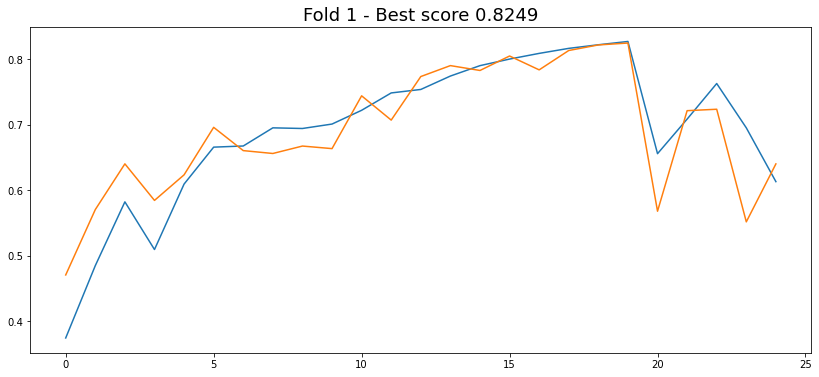

========== fold: 0 result ==========
Score (without expiratory phase): 0.8249
========== fold: 1 training ==========


init LSTM(55, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.3964  avg_val_loss: 0.2574  time: 10s, lr: 0.00099, ACC: 0.2574, Best Score
Epoch 2 - avg_train_loss: 0.4820  avg_val_loss: 0.6445  time: 10s, lr: 0.00098, ACC: 0.6445, Best Score
Epoch 3 - avg_train_loss: 0.6258  avg_val_loss: 0.6549  time: 10s, lr: 0.00095, ACC: 0.6549, Best Score
Epoch 4 - avg_train_loss: 0.6646  avg_val_loss: 0.7028  time: 10s, lr: 0.00091, ACC: 0.7028, Best Score
Epoch 5 - avg_train_loss: 0.6895  avg_val_loss: 0.7107  time: 10s, lr: 0.00086, ACC: 0.7107, Best Score
Epoch 6 - avg_train_loss: 0.7008  avg_val_loss: 0.7129  time: 10s, lr: 0.00080, ACC: 0.7129, Best Score
Epoch 7 - avg_train_loss: 0.7308  avg_val_loss: 0.7492  time: 10s, lr: 0.00073, ACC: 0.7492, Best Score
Epoch 8 - avg_train_loss: 0.7489  avg_val_loss: 0.7686  time: 10s, lr: 0.00066, ACC: 0.7686, Best Score
Epoch 9 - avg_train_loss: 0.7600  avg_val_loss: 0.7368  time: 10s, lr: 0.00058, ACC: 0.7368, 
Epoch 10 - avg_train_loss: 0.7719  avg_val_loss: 0.7822  time: 10s, lr: 0.

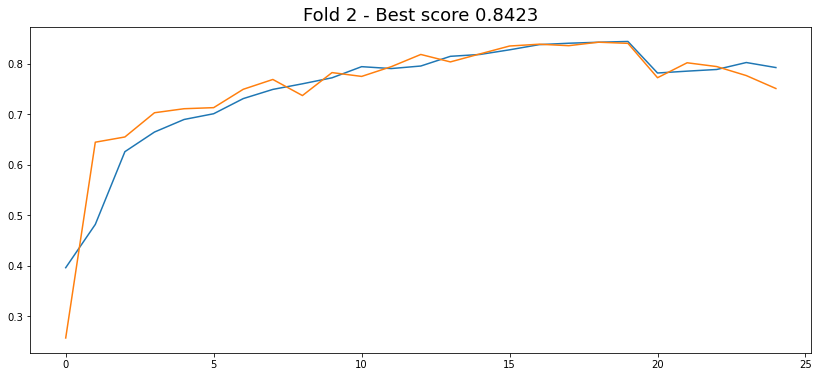

========== fold: 1 result ==========
Score (without expiratory phase): 0.8423
========== fold: 2 training ==========


init LSTM(55, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.4216  avg_val_loss: 0.4351  time: 10s, lr: 0.00099, ACC: 0.4351, Best Score
Epoch 2 - avg_train_loss: 0.5124  avg_val_loss: 0.5270  time: 10s, lr: 0.00098, ACC: 0.5270, Best Score
Epoch 3 - avg_train_loss: 0.4789  avg_val_loss: 0.5534  time: 10s, lr: 0.00095, ACC: 0.5534, Best Score
Epoch 4 - avg_train_loss: 0.6020  avg_val_loss: 0.6520  time: 10s, lr: 0.00091, ACC: 0.6520, Best Score
Epoch 5 - avg_train_loss: 0.6648  avg_val_loss: 0.6926  time: 10s, lr: 0.00086, ACC: 0.6926, Best Score
Epoch 6 - avg_train_loss: 0.6876  avg_val_loss: 0.6816  time: 10s, lr: 0.00080, ACC: 0.6816, 
Epoch 7 - avg_train_loss: 0.7021  avg_val_loss: 0.7038  time: 10s, lr: 0.00073, ACC: 0.7038, Best Score
Epoch 8 - avg_train_loss: 0.7146  avg_val_loss: 0.7239  time: 10s, lr: 0.00066, ACC: 0.7239, Best Score
Epoch 9 - avg_train_loss: 0.7109  avg_val_loss: 0.7189  time: 10s, lr: 0.00058, ACC: 0.7189, 
Epoch 10 - avg_train_loss: 0.7287  avg_val_loss: 0.7462  time: 10s, lr: 0.00051, ACC

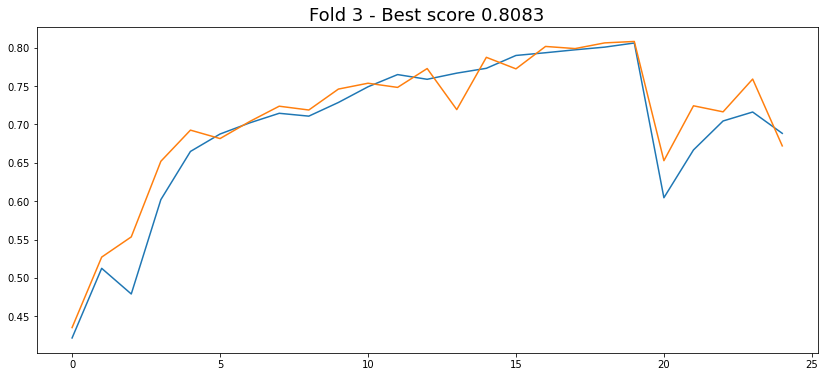

========== fold: 2 result ==========
Score (without expiratory phase): 0.8083
========== fold: 3 training ==========


init LSTM(55, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.4192  avg_val_loss: 0.5647  time: 10s, lr: 0.00099, ACC: 0.5647, Best Score
Epoch 2 - avg_train_loss: 0.5158  avg_val_loss: 0.5409  time: 10s, lr: 0.00098, ACC: 0.5409, 
Epoch 3 - avg_train_loss: 0.5962  avg_val_loss: 0.6459  time: 10s, lr: 0.00095, ACC: 0.6459, Best Score
Epoch 4 - avg_train_loss: 0.6506  avg_val_loss: 0.6640  time: 10s, lr: 0.00091, ACC: 0.6640, Best Score
Epoch 5 - avg_train_loss: 0.6569  avg_val_loss: 0.6874  time: 10s, lr: 0.00086, ACC: 0.6874, Best Score
Epoch 6 - avg_train_loss: 0.6840  avg_val_loss: 0.7119  time: 10s, lr: 0.00080, ACC: 0.7119, Best Score
Epoch 7 - avg_train_loss: 0.7015  avg_val_loss: 0.7056  time: 10s, lr: 0.00073, ACC: 0.7056, 
Epoch 8 - avg_train_loss: 0.7230  avg_val_loss: 0.7414  time: 10s, lr: 0.00066, ACC: 0.7414, Best Score
Epoch 9 - avg_train_loss: 0.7428  avg_val_loss: 0.7429  time: 10s, lr: 0.00058, ACC: 0.7429, Best Score
Epoch 10 - avg_train_loss: 0.7619  avg_val_loss: 0.7665  time: 10s, lr: 0.00051, ACC

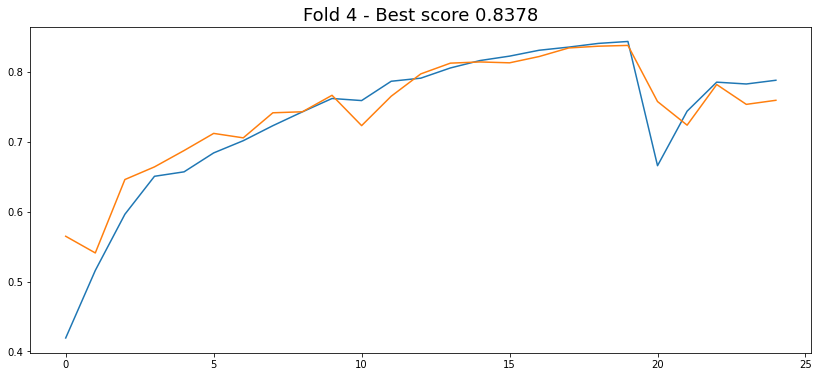

========== fold: 3 result ==========
Score (without expiratory phase): 0.8378
========== fold: 4 training ==========


init LSTM(55, 1024, batch_first=True, bidirectional=True)
init LSTM(2048, 512, batch_first=True, bidirectional=True)
init LSTM(1024, 256, batch_first=True, bidirectional=True)
init LSTM(1536, 128, batch_first=True, bidirectional=True)


Epoch 1 - avg_train_loss: 0.3836  avg_val_loss: 0.2211  time: 10s, lr: 0.00099, ACC: 0.2211, Best Score
Epoch 2 - avg_train_loss: 0.4780  avg_val_loss: 0.5893  time: 10s, lr: 0.00098, ACC: 0.5893, Best Score
Epoch 3 - avg_train_loss: 0.5333  avg_val_loss: 0.5819  time: 10s, lr: 0.00095, ACC: 0.5819, 
Epoch 4 - avg_train_loss: 0.6167  avg_val_loss: 0.6423  time: 10s, lr: 0.00091, ACC: 0.6423, Best Score
Epoch 5 - avg_train_loss: 0.6506  avg_val_loss: 0.6636  time: 10s, lr: 0.00086, ACC: 0.6636, Best Score
Epoch 6 - avg_train_loss: 0.6784  avg_val_loss: 0.7048  time: 10s, lr: 0.00080, ACC: 0.7048, Best Score
Epoch 7 - avg_train_loss: 0.6970  avg_val_loss: 0.6366  time: 10s, lr: 0.00073, ACC: 0.6366, 
Epoch 8 - avg_train_loss: 0.7333  avg_val_loss: 0.7554  time: 10s, lr: 0.00066, ACC: 0.7554, Best Score
Epoch 9 - avg_train_loss: 0.7439  avg_val_loss: 0.7541  time: 10s, lr: 0.00058, ACC: 0.7541, 
Epoch 10 - avg_train_loss: 0.7659  avg_val_loss: 0.7380  time: 10s, lr: 0.00051, ACC: 0.7380, 

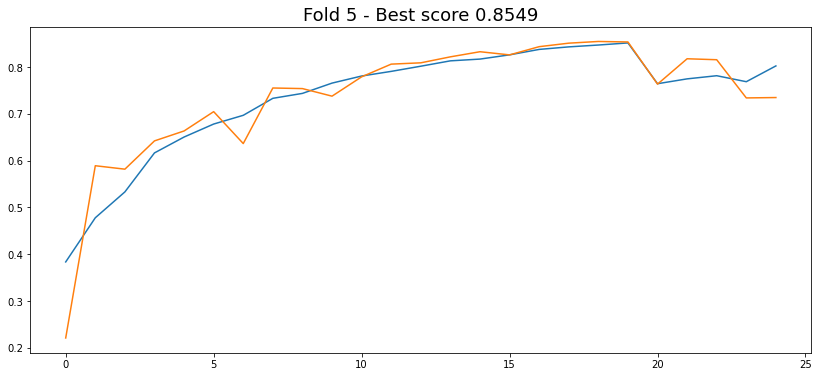

========== fold: 4 result ==========
Score (without expiratory phase): 0.8549
========== CV ==========
Score (without expiratory phase): 0.8336


[fold0] avg_train_loss,▁▃▄▃▅▆▆▆▆▆▆▇▇▇▇█████▅▆▇▆▅
[fold0] avg_val_loss,▁▃▄▃▄▅▅▅▅▅▆▆▇▇▇█▇███▃▆▆▃▄
[fold0] best_score,▁▃▄▄▄▅▅▅▅▅▆▆▇▇▇██████████
[fold0] epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
[fold0] loss,▆▆▅▅▄▄█▄▃▃▃▃▂▃▃▃▃▂▂▂▂▂▃▂▁▂▁▁▁▁▁▁▄▅▂▂▃▂▅▄
[fold0] lr,███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁██████▇▇
[fold0] score,▁▃▄▃▄▅▅▅▅▅▆▆▇▇▇█▇███▃▆▆▃▄
[fold1] avg_train_loss,▁▂▅▅▆▆▆▇▇▇▇▇▇███████▇▇▇▇▇
[fold1] avg_val_loss,▁▆▆▆▆▆▇▇▇▇▇▇████████▇█▇▇▇
[fold1] best_score,▁▆▆▆▆▆▇▇▇▇▇▇█████████████
[fold1] epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


In [20]:
if __name__ == '__main__':
    main()

### R and C predictoin EDA

In [40]:
oof_df = pd.read_csv('./results/1101_C_classificatoin_lstm_hidden=1024_ver11_mod-feat11/oof_df.csv')

In [41]:
oof_df = pd.concat([oof_df, oof_df['preds'].str.split('_', expand=True)], axis=1)
oof_df.rename(columns={0: 'R_pred', 1: 'C_pred'}, inplace=True)
oof_df = oof_df[['breath_id', 'R', 'C', 'R_pred', 'C_pred']]
oof_df['R_pred'] = oof_df['R_pred'].astype('int64')
oof_df['C_pred'] = oof_df['C_pred'].astype('int64')

In [43]:
display(oof_df.head())
display(oof_df.info())

,breath_id,R,C,R_pred,C_pred
0,5,5,50,5,50
1,15,20,20,20,10
2,42,50,20,50,10
3,47,50,20,50,50
4,49,50,10,50,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75450 entries, 0 to 75449
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   breath_id  75450 non-null  int64
 1   R          75450 non-null  int64
 2   C          75450 non-null  int64
 3   R_pred     75450 non-null  int64
 4   C_pred     75450 non-null  int64
dtypes: int64(5)
memory usage: 2.9 MB


None

In [45]:
print(len(oof_df[oof_df['R']!=oof_df['R_pred']]))
print(len(oof_df[oof_df['C']!=oof_df['C_pred']]))
print(len(oof_df[(oof_df['R']!=oof_df['R_pred']) & (oof_df['C']!=oof_df['C_pred'])]))

2
12552
2


### pressure prediction EDA

In [46]:
pressure_oof_df = pd.read_csv('./results/1031_lstm_hidden=1024_ver11_mod-feat11_dropout=0.0/oof_df.csv')

In [47]:
pressure_oof_df.head()

,u_out,id,breath_id,R,C,time_step,u_in,pressure,area@AddMultiplyingDividing,u_in_cumsum@AddMultiplyingDividing,u_in_cummean@AddMultiplyingDividing,time_step_cumsum@AddMultiplyingDividing,breath_id__u_in__max@AddMultiplyingDividing,breath_id__u_in__mean@AddMultiplyingDividing,breath_id__u_in__diffmax@AddMultiplyingDividing,breath_id__u_in__diffmean@AddMultiplyingDividing,breath_time@AddBreathTimeAndUInTime,u_in_time@AddBreathTimeAndUInTime,R_dummy_20@RCDummry,R_dummy_5@RCDummry,R_dummy_50@RCDummry,C_dummy_10@RCDummry,C_dummy_20@RCDummry,C_dummy_50@RCDummry,u_in_lag1@LagFeatures,u_in_lag2@LagFeatures,u_in_lag3@LagFeatures,u_in_lag4@LagFeatures,u_in_lag-1@LagFeatures,u_in_lag-2@LagFeatures,u_in_lag-3@LagFeatures,u_in_lag-4@LagFeatures,u_out_lag1@LagFeatures,u_out_lag2@LagFeatures,u_out_lag3@LagFeatures,u_out_lag4@LagFeatures,u_out_lag-1@LagFeatures,u_out_lag-2@LagFeatures,u_out_lag-3@LagFeatures,u_out_lag-4@LagFeatures,u_in_lag1_diff@LagFeatures,u_in_lag2_diff@LagFeatures,u_in_lag3_diff@LagFeatures,u_in_lag4_diff@LagFeatures,u_out_lag1_diff@LagFeatures,u_out_lag2_diff@LagFeatures,u_out_lag3_diff@LagFeatures,u_out_lag4_diff@LagFeatures,u_in_lag-1_diff@LagFeatures,u_in_lag-2_diff@LagFeatures,u_out_lag-1_diff@LagFeatures,u_out_lag-2_diff@LagFeatures,u_in_ewm9@LagFeatures,u_in_ewm15@LagFeatures,u_in_rolling_mean4@LagFeatures,u_in_rolling_mean15@LagFeatures,u_in_rolling_max4@LagFeatures,u_in_rolling_max15@LagFeatures,u_in_rolling_min4@LagFeatures,u_in_rolling_min15@LagFeatures,u_in_rolling_std4@LagFeatures,u_in_rolling_std15@LagFeatures,u_in_rolling_sum4@LagFeatures,u_in_rolling_sum15@LagFeatures,preds
0,0,321,5,-0.333333,0.75,-0.989052,3.711844,6.329607,-0.516581,-0.669042,1.244003,-0.496658,0.250038,1.29823,-0.104509,-1.603273,-15.475736,-0.044814,0.0,1.0,0.0,0.0,0.0,1.0,-0.864121,-0.842527,-0.819258,-0.794152,4.974032,5.039258,5.291232,5.418787,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,132.850119,68.492546,44.401453,30.666883,0.0,0.0,0.0,0.0,-48.015476,-23.866392,0.0,0.0,2.688075,2.199953,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347,6.263166
1,0,322,5,-0.333333,0.75,-0.963370,5.254311,7.384139,-0.512590,-0.593995,1.557929,-0.496018,0.250038,1.29823,-0.300043,-2.657233,0.249007,48.015476,0.0,1.0,0.0,0.0,0.0,1.0,3.444823,-0.842527,-0.819258,-0.794152,5.148694,5.270160,5.396331,5.660313,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.873530,91.143870,59.092289,40.818514,0.0,0.0,0.0,0.0,-5.713859,-5.986590,0.0,0.0,3.267327,2.682936,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347,7.325165
2,0,323,5,-0.333333,0.75,-0.937036,5.439132,8.368369,-0.504267,-0.516715,1.687647,-0.494722,0.250038,1.29823,-0.323472,-2.783520,0.648565,5.713859,0.0,1.0,0.0,0.0,0.0,1.0,4.868833,3.461791,-0.819258,-0.794152,5.385263,5.375165,5.637683,5.688518,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.216949,25.316838,60.852572,42.034902,0.0,0.0,0.0,0.0,-7.754964,-5.004396,0.0,0.0,3.508059,2.883281,0.479105,0.369347,0.643385,0.88922,0.344693,0.316541,1.618068,0.575588,0.479105,0.369347,8.345636
3,0,324,5,-0.333333,0.75,-0.911317,5.689461,9.001088,-0.491343,-0.436410,1.777980,-0.492785,0.250038,1.29823,-0.355206,-2.954569,0.271413,7.754964,0.0,1.0,0.0,0.0,0.0,1.0,5.039460,4.884272,3.488656,-0.794152,5.492845,5.616303,5.665868,5.787857,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.082176,6.341633,18.783437,43.682426,0.0,0.0,0.0,0.0,-3.502223,-5.157942,0.0,0.0,3.678685,3.024349,4.263476,0.369347,3.884071,0.88922,3.552080,0.316541,4.364297,0.575588,4.263476,0.369347,9.012208
4,0,325,5,-0.333333,0.75,-0.885525,5.803301,9.774412,-0.473835,-0.354729,1.841448,-0.490206,0.250038,1.29823,-0.369637,-3.032356,0.316446,3.502223,0.0,1.0,0.0,0.0,0.0,1.0,5.270565,5.054716,4.912325,3.518006,5.739901,5.644463,5.765135,5.726151,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.195885,5.299265,5.176842,13.713604,0.0,0.0,0.0,0.0,-8.100707,-4.005137,0.0,0.0,3.799753,3.124122,4.710389,0.369347,3.962919,0.88922,4.980904,0.3165

In [71]:
masked_df = pressure_oof_df[['u_out', 'breath_id', 'R', 'C', 'pressure', 'preds']]
masked_df['error'] = np.abs(df['target']-df['preds'])

masked_df['error'] = masked_df.mask(masked_df['u_out']==1)['error']

In [72]:
masked_df = pd.merge(masked_df[['u_out', 'breath_id', 'pressure', 'preds', 'error']], oof_df[['breath_id', 'R', 'C', 'R_pred', 'C_pred']], on='breath_id')

In [73]:
masked_target_df = masked_df[masked_df['C']!=masked_df['C_pred']]

In [74]:
masked_target_df.head()

,u_out,breath_id,pressure,preds,error,R,C,R_pred,C_pred
80,0,15,6.118700,5.832244,0.286456,20,20,20,10
81,0,15,8.508973,8.466134,0.042839,20,20,20,10
82,0,15,12.094383,11.844680,0.249703,20,20,20,10
83,0,15,17.156137,17.329708,0.173571,20,20,20,10
84,0,15,17.788856,18.125238,0.336382,20,20,20,10


In [75]:
MAE_id = masked_df.groupby('breath_id').agg(np.nanmean)['error']
MAE_target_id = masked_target_df.groupby('breath_id').agg(np.nanmean)['error']

In [76]:
MAE_id.head()

breath_id
1    0.058857
2    0.067227
3    0.065054
4    0.236647
5    0.050873
Name: error, dtype: float64

In [77]:
MAE_id.describe()

count    75450.000000
mean         0.170554
std          0.287534
min          0.013023
25%          0.069512
50%          0.102849
75%          0.167612
max         21.123314
Name: error, dtype: float64

In [78]:
MAE_target_id.describe()

count    12552.000000
mean         0.223626
std          0.354280
min          0.018833
25%          0.084456
50%          0.126575
75%          0.216160
max         10.277465
Name: error, dtype: float64

<AxesSubplot:>

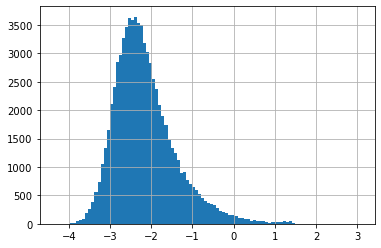

In [102]:
np.log(MAE_id).hist(bins=100)

<AxesSubplot:>

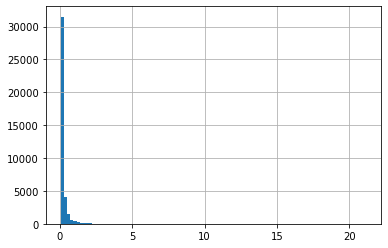

In [101]:
MAE_id.where(MAE_id > 0.1).hist(bins=100)

In [207]:
target_id = MAE_id.where(MAE_id > 1.0).dropna()
len(target_id)

1107

In [208]:
masked_target_df[(masked_target_df['C']!=masked_target_df['C_pred']) & (masked_target_df['breath_id'].isin(target_id.index.tolist()))].head()

,u_out,breath_id,pressure,preds,error,R,C,R_pred,C_pred
2480,0,324,6.681117,6.792830,0.111713,50,50,50,20
2481,0,324,5.907794,6.125059,0.217265,50,50,50,20
2482,0,324,9.563505,10.276590,0.713085,50,50,50,20
2483,0,324,18.070065,19.230728,1.160663,50,50,50,20
2484,0,324,23.834841,25.788916,1.954075,50,50,50,20


## make changed data

In [209]:
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [210]:
display(train[train['breath_id']==324].head())
display(oof_df[oof_df['breath_id']==324].head())

,id,breath_id,R,C,time_step,u_in,u_out,pressure
17520,17521,324,50,50,0.000000,1.827899,0,6.681117
17521,17522,324,50,50,0.031733,15.058852,0,5.907794
17522,17523,324,50,50,0.063469,20.591254,0,9.563505
17523,17524,324,50,50,0.095300,20.729662,0,18.070065
17524,17525,324,50,50,0.127149,19.683303,0,23.834841


,breath_id,R,C,R_pred,C_pred
31,324,50,50,50,20


In [202]:
# 全てのCを変更
# train = pd.merge(train, oof_df[['breath_id', 'C_pred']], on='breath_id')
# train['C'] = train['C_pred']
# train = train.drop(['C_pred'], axis=1)

In [211]:
# target_idのみ変更
train = pd.merge(train, oof_df[['breath_id', 'C_pred']], on='breath_id')
#train[train['breath_id'].isin(target_id.index.tolist())]['C'] = train[train['breath_id'].isin(target_id.index.tolist())]['C_pred']
train['C'] = train['C'].mask(train['breath_id'].isin(target_id.index.tolist()), train['C_pred'])
train = train.drop(['C_pred'], axis=1)
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [203]:
display(train[train['breath_id']==324].head())
display(oof_df[oof_df['breath_id']==324].head())

,id,breath_id,R,C,time_step,u_in,u_out,pressure
17520,17521,324,50,20,0.000000,1.827899,0,6.681117
17521,17522,324,50,20,0.031733,15.058852,0,5.907794
17522,17523,324,50,20,0.063469,20.591254,0,9.563505
17523,17524,324,50,20,0.095300,20.729662,0,18.070065
17524,17525,324,50,20,0.127149,19.683303,0,23.834841


,breath_id,R,C,R_pred,C_pred
31,324,50,50,50,20


In [204]:
os.makedirs('../input/ventilator-pressure-prediction/C_change/', exist_ok=True)
train.to_csv(f'../input/ventilator-pressure-prediction/C_change/train.csv', index=False)

In [212]:
os.makedirs('../input/ventilator-pressure-prediction/C_change_1.0/', exist_ok=True)
train.to_csv(f'../input/ventilator-pressure-prediction/C_change_1.0/train.csv', index=False)